# Scryfall Analysis - Cube Structure

__Objective:__ Connect to publicly available data on Scryfall through their REST API to identify patterns set design.

In [1]:
import datetime
print("Script last ran on", datetime.datetime.today().strftime("%m/%d/%Y"))

Script last ran on 06/14/2021


In [2]:
# libraries
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import re
import requests

In [5]:
pioneer = pd.read_csv('scryfall_pioneer_20210614.csv')
pioneer.head()

,Unnamed: 0,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,set,set_name,rarity,edhrec_rank,produced_mana,printed_name,printed_text,legalities,lang
0,3,Siren Lookout,{2}{U},3.0,Creature — Siren Pirate,Flying\nWhen Siren Lookout enters the battlefi...,1.0,2.0,['U'],['U'],"['Flying', 'Explore']",xln,Ixalan,common,9491.0,NaN,NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",en
1,21,Charge,{W},1.0,Instant,Creatures you control get +1/+1 until end of t...,NaN,NaN,['W'],['W'],[],dom,Dominaria,common,11723.0,NaN,NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",en
2,31,Destructive Tampering,{2}{R},3.0,Sorcery,Choose one —\n• Destroy target artifact.\n• Cr...,NaN,NaN,['R'],['R'],[],aer,Aether Revolt,common,10439.0,NaN,NaN,NaN,"{'standard': 'legal', 'future': 'legal', 'hist...",en
3,58,Shock,{R},1.0,Instant,Shock deals 2 damage to any target.,NaN,NaN,['R'],['R'],[],aer,Aether Revolt,common,2878.0,NaN,NaN,NaN,"{'standard': 'legal', 'future': 'legal', 'hist...",en
4,74,Initiate's Companion,{1}{G},2.0,Creature — Cat,Whenever Initiate's Companion deals combat dam...,3.0,1.0,['G'],['G'],[],akh,Amonkhet,common,9563.0,NaN,NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",en


In [62]:
# tidy dataframe
## evasion bool
evasion_keywords = ['Flying', 'Trample', 'Menace',
                    'Plainswalk', 'Islandwalk', 'Forestwalk', 'Mountainwalk', 'Swampwalk',
                    'Skulk', 'Shadow', 'Fear', 'Intimidate']
pioneer['evasion'] = pioneer['keywords'].apply(lambda x: bool(any(item in x for item in evasion_keywords)))

## removal bool
removal_regexes = [
    # white removal
    re.compile(r'enchanted (creature|permanent) can\'t attack (?!until end of turn)'),
    re.compile(r'exile target (?!card)'),
    
    # blue removal
    re.compile(r'enchanted creature doesn\'t untap'),
    re.compile(r'return target (creature|nonland permanent) to its owner\'s hand'),
    re.compile(r'put target (creature|permanent)'),
    
    # black removal
    re.compile(r'destroy target (creature|permanent)'),
    re.compile(r'target (player|opponent) sacrifice'),
    re.compile(r'(\+|-)[0-9]*/-[1-9]* until end of turn'),
    
    # red removal
    re.compile(r'deals [0-9]* damage'),
    
    # green removal
    re.compile(r'deals damage equal'),
    re.compile(r'target creature .* control(s)? fight')
]

pioneer['removal'] = pioneer['oracle_text'].astype(str).apply(lambda x: bool(any(regex.search(x.lower()) for regex in removal_regexes)))

## combat trick bool
combat_regexes = [
    re.compile(r'target creature .* gets (\+|-)[0-9]*/(\+|-)[0-9]*'),
    re.compile(r'tap target creature'),
    re.compile(r'tap up to (two|three|four) target creature'),
    re.compile(r'target creature can\'t block this turn'),
    re.compile(r'creatures can\'t block'),
    re.compile(r'target creature blocks this turn if able'),
    re.compile(r'target creature gains .* until end of turn'),
    re.compile(r'\+1/\+1 (counter|counters) on target creature'),
    re.compile(r'untap target creature'),
    re.compile(r'creatures you control .* until end of turn')
]

pioneer['combat_trick'] = pioneer['oracle_text'].astype(str).apply(lambda x: bool(any(regex.search(x.lower()) for regex in combat_regexes)))

pioneer.head()

,Unnamed: 0,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,...,rarity,edhrec_rank,produced_mana,printed_name,printed_text,legalities,lang,evasion,removal,combat_trick
0,3,Siren Lookout,{2}{U},3.0,Creature — Siren Pirate,Flying\nWhen Siren Lookout enters the battlefi...,1.0,2.0,['U'],['U'],...,common,9491.0,NaN,NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",en,True,False,False
1,21,Charge,{W},1.0,Instant,Creatures you control get +1/+1 until end of t...,NaN,NaN,['W'],['W'],...,common,11723.0,NaN,NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",en,False,False,True
2,31,Destructive Tampering,{2}{R},3.0,Sorcery,Choose one —\n• Destroy target artifact.\n• Cr...,NaN,NaN,['R'],['R'],...,common,10439.0,NaN,NaN,NaN,"{'standard': 'legal', 'future': 'legal', 'hist...",en,False,False,False
3,58,Shock,{R},1.0,Instant,Shock deals 2 damage to any target.,NaN,NaN,['R'],['R'],...,common,2878.0,NaN,NaN,NaN,"{'standard': 'legal', 'future': 'legal', 'hist...",en,False,True,False
4,74,Initiate's Companion,{1}{G},2.0,Creature — Cat,Whenever Initiate's Companion deals combat dam...,3.0,1.0,['G'],['G'],...,common,9563.0,NaN,NaN,NaN,"{'standard': 'not_legal', 'future': 'not_legal...",en,False,False,True


## Summary Statistics by Set

In [63]:
card_type_breakdown = pioneer.groupby('set_name').size().reset_index(name = 'commons') # number of commons

card_types = ['Creature', 'Enchantment', 'Instant', 'Sorcery', 'Artifact']
for card_type in card_types:
    new_df = pioneer[pioneer['type_line'].str.contains(card_type)].groupby('set_name').size().reset_index(name = card_type + "s")
    card_type_breakdown = card_type_breakdown.merge(new_df, how = 'left', on = 'set_name')

print('\nCard Type Breakdown\n')
card_type_breakdown = card_type_breakdown.replace(np.nan, 0)
card_type_breakdown


Card Type Breakdown



,set_name,commons,Creatures,Enchantments,Instants,Sorcerys,Artifacts
0,Aether Revolt,75,40,4.0,12,8,21.0
1,Amonkhet,99,55,9.0,24,9,2.0
2,Battle for Zendikar,95,55,3.0,21,15,1.0
3,Born of the Gods,60,32,14.0,12,7,0.0
4,Core Set 2019,113,66,7.0,23,13,7.0
5,Core Set 2020,141,90,11.0,22,15,6.0
6,Dominaria,103,56,5.0,24,13,11.0
7,Dragon's Maze,60,30,2.0,8,10,10.0
8,Dragons of Tarkir,100,56,5.0,25,12,5.0
9,Eldritch Moon,75,40,7.0,13,12,4.0


## White

In [64]:
white = pioneer[pioneer['color_identity'].astype(str).str.contains("W")]
card_type_breakdown_w = white.groupby('set_name').size().reset_index(name = 'commons') # number of commons

card_types = ['Creature', 'Enchantment', 'Instant', 'Sorcery', 'Artifact']
for card_type in card_types:
    new_df = white[white['type_line'].str.contains(card_type)].groupby('set_name').size().reset_index(name = card_type + "s")
    card_type_breakdown_w = card_type_breakdown_w.merge(new_df, how = 'left', on = 'set_name')

print('\nCard Type Breakdown For White\n')
card_type_breakdown_w = card_type_breakdown_w.replace(np.nan, 0).set_index('set_name')
ctypes_ratio_w = card_type_breakdown_w.iloc[:, 1:].div(card_type_breakdown_w.commons, axis = 0)
ratio_sums = [row.Creatures + row.Enchantments + row.Instants + row.Sorcerys + row.Artifacts for index, row in ctypes_ratio_w.iterrows()]
ctypes_ratio_w['ratio_sums'] = ratio_sums
ctypes_ratio_w.head()


Card Type Breakdown For White



,Creatures,Enchantments,Instants,Sorcerys,Artifacts,ratio_sums
set_name,,,,,,
Aether Revolt,0.571429,0.142857,0.142857,0.071429,0.142857,1.071429
Amonkhet,0.650000,0.100000,0.250000,0.000000,0.000000,1.000000
Battle for Zendikar,0.611111,0.055556,0.277778,0.055556,0.000000,1.000000
Born of the Gods,0.583333,0.166667,0.166667,0.166667,0.000000,1.083333
Core Set 2019,0.666667,0.095238,0.190476,0.047619,0.000000,1.000000


In [65]:
# cart_type_w_long = pd.melt(card_type_breakdown_w, value_vars = ['Creatures', 'Enchantments', 'Instants', 'Sorcerys', 'Artifacts'],  var_name = 'card_type')

### Creatures

#### Average Curve

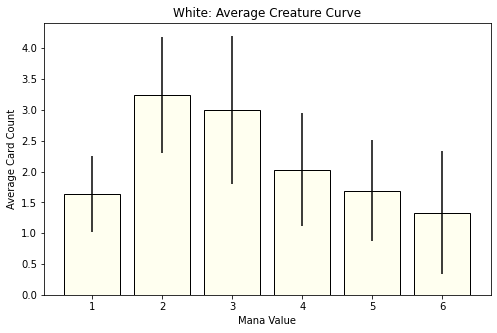

In [66]:
# white creatures df
white_creatures = white[white['type_line'].str.contains('Creature')]
creature_curve_df_w = white_creatures.groupby(['set_name', 'cmc']).size().reset_index(name = 'cards')
creature_curve_df_w = creature_curve_df_w.groupby('cmc').cards.agg(['mean', 'min', 'max', 'std']).reset_index()
creature_curve_df_w['count_ratio'] = creature_curve_df_w['mean'] / creature_curve_df_w['mean'].sum()

# white creature curve
plt.figure(figsize = (8,5))
plt.bar(x = creature_curve_df_w['cmc'], height = creature_curve_df_w['mean'], yerr = creature_curve_df_w['std'],
        color = 'ivory', edgecolor = 'black')
plt.ylabel('Average Card Count')
plt.xlabel('Mana Value')
plt.title('White: Average Creature Curve');

In [67]:
creature_ratio_w = ctypes_ratio_w['Creatures'].mean()
print("Average percent of white cards which are creatures:", creature_ratio_w, "\n")

for index, row in creature_curve_df_w.iterrows():
  print("\tRatio of", row['cmc'], "drops:", row['count_ratio'])

Average percent of white cards which are creatures: 0.6079410458257112 

	Ratio of 1.0 drops: 0.12635156913880505
	Ratio of 2.0 drops: 0.2508277903126556
	Ratio of 3.0 drops: 0.2320743106631113
	Ratio of 4.0 drops: 0.1570603920649339
	Ratio of 5.0 drops: 0.13054179974800012
	Ratio of 6.0 drops: 0.10314413807249391


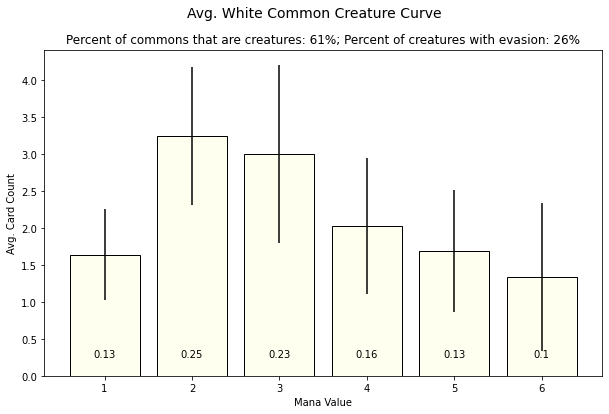

In [167]:
# stats
creature_ratio_w = ctypes_ratio_w['Creatures'].mean()
creatures_w_evasion = len(white_creatures[white_creatures['evasion'] == True]) / len(white_creatures)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
#fig.subplots_adjust(top = 0.85)

# set axis titles and plot titles
fig.suptitle('Avg. White Common Creature Curve', fontsize = 14)
ax.set_title('Percent of commons that are creatures: {}; Percent of creatures with evasion: {}'.
             format(str(round(100 * creature_ratio_w)) + '%', str(round(100*creatures_w_evasion)) + '%'))
ax.set_xlabel('Mana Value')
ax.set_ylabel('Avg. Card Count')

# adjust plot limits
#ax.axis([0,max(creature_curve_df_w['cmc']),0,max(creature_curve_df_w['mean'] + max(creature_curve_df_w['std']))])

# insert bar chart
plt.bar(x = creature_curve_df_w['cmc'], height = creature_curve_df_w['mean'], yerr = creature_curve_df_w['std'],
        color = 'ivory', edgecolor = 'black')

# insert texts
for index, row in creature_curve_df_w.iterrows():
    ax.text(row['cmc'], 0.25, round(row['count_ratio'], 2), horizontalalignment = 'center')
    
fig;

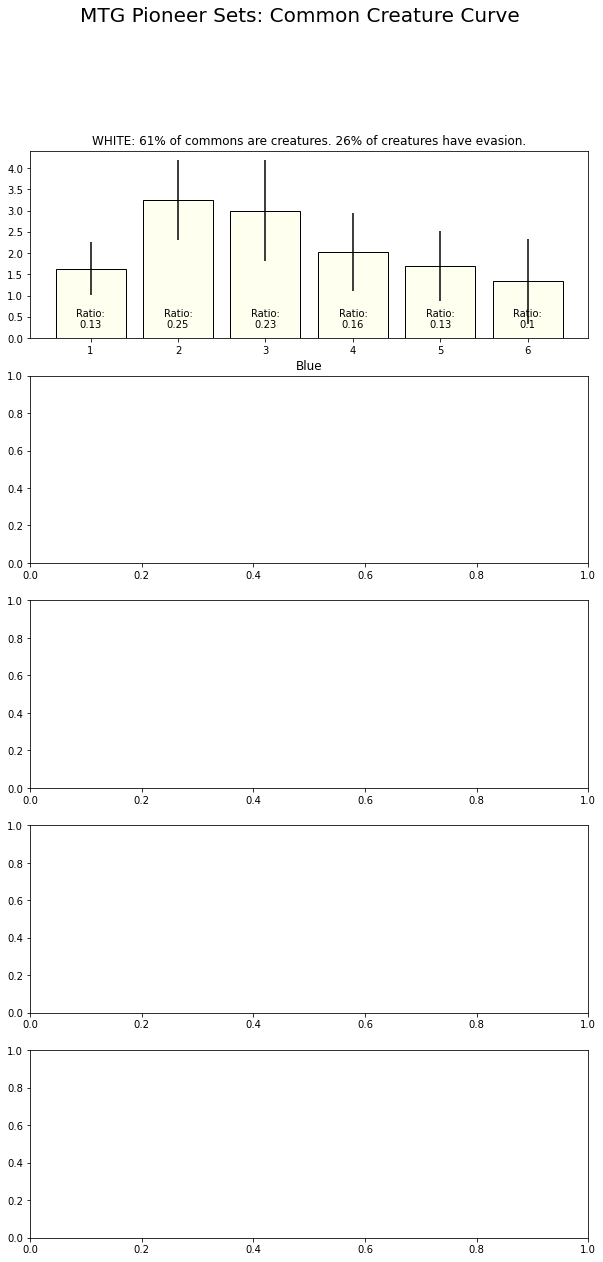

In [180]:
fig, axs = plt.subplots(5,1)
fig.set_figheight(20)
fig.set_figwidth(10)
fig.suptitle('MTG Pioneer Sets: Common Creature Curve', fontsize = 20)

# subplot 1: white
axs[0].set_title('WHITE: {} of commons are creatures. {} of creatures have evasion.'.
             format(str(round(100 * creature_ratio_w)) + '%', str(round(100*creatures_w_evasion)) + '%'))
axs[0].bar(x = creature_curve_df_w['cmc'], height = creature_curve_df_w['mean'], yerr = creature_curve_df_w['std'],
           color = 'ivory', edgecolor = 'black')
for index, row in creature_curve_df_w.iterrows():
    axs[0].text(row['cmc'], 0.5, 'Ratio:', horizontalalignment = 'center')
    axs[0].text(row['cmc'], 0.25, round(row['count_ratio'], 2), horizontalalignment = 'center')


# subplot 2: blue
axs[1].set_title('Blue')

fig;

### Non-Creatures

## Blue

In [ ]:
blue = pioneer[pioneer['color_identity'].astype(str).str.contains("U")]
card_type_breakdown_u = blue.groupby('set_name').size().reset_index(name = 'commons') # number of commons

card_types = ['Creature', 'Enchantment', 'Instant', 'Sorcery', 'Artifact']
for card_type in card_types:
    new_df = blue[blue['type_line'].str.contains(card_type)].groupby('set_name').size().reset_index(name = card_type + "s")
    card_type_breakdown_u = card_type_breakdown_u.merge(new_df, how = 'left', on = 'set_name')

print('\nCard Type Breakdown For Blue\n')
card_type_breakdown_u = card_type_breakdown_u.replace(np.nan, 0).set_index('set_name')
ctypes_ratio_u = card_type_breakdown_u.iloc[:, 1:].div(card_type_breakdown_u.commons, axis = 0)
ratio_sums = [row.Creatures + row.Enchantments + row.Instants + row.Sorcerys + row.Artifacts for index, row in ctypes_ratio_u.iterrows()]
ctypes_ratio_u['ratio_sums'] = ratio_sums
ctypes_ratio_u.head()

### Creatures

In [ ]:
# blue creatures df
blue_creatures = blue[blue['type_line'].str.contains('Creature')]
creature_curve_df_u = blue_creatures.groupby(['set_name', 'cmc']).size().reset_index(name = 'cards')
creature_curve_df_u = creature_curve_df_u.groupby('cmc').cards.agg(['mean', 'min', 'max', 'std']).reset_index()
creature_curve_df_u['count_ratio'] = creature_curve_df_u['mean'] / creature_curve_df_u['mean'].sum()

# blue creature curve
plt.figure(figsize = (8,5))
plt.bar(x = creature_curve_df_u['cmc'], height = creature_curve_df_u['mean'], yerr = creature_curve_df_u['std'],
        color = 'dodgerblue', edgecolor = 'black')
plt.ylabel('Average Card Count')
plt.xlabel('Mana Value')
plt.title('Blue: Average Creature Curve');

In [ ]:
creature_ratio_u = ctypes_ratio_u['Creatures'].mean()
print("Average percent of blue cards which are creatures:", creature_ratio_u, "\n")

for index, row in creature_curve_df_u.iterrows():
  print("\tRatio of", row['cmc'], "drops:", row['count_ratio'])

## Black

In [ ]:
black = pioneer[pioneer['color_identity'].astype(str).str.contains("B")]
card_type_breakdown_b = black.groupby('set_name').size().reset_index(name = 'commons') # number of commons

card_types = ['Creature', 'Enchantment', 'Instant', 'Sorcery', 'Artifact']
for card_type in card_types:
    new_df = black[black['type_line'].str.contains(card_type)].groupby('set_name').size().reset_index(name = card_type + "s")
    card_type_breakdown_b = card_type_breakdown_b.merge(new_df, how = 'left', on = 'set_name')

print('\nCard Type Breakdown For Black\n')
card_type_breakdown_b = card_type_breakdown_b.replace(np.nan, 0).set_index('set_name')
ctypes_ratio_b = card_type_breakdown_b.iloc[:, 1:].div(card_type_breakdown_b.commons, axis = 0)
ratio_sums = [row.Creatures + row.Enchantments + row.Instants + row.Sorcerys + row.Artifacts for index, row in ctypes_ratio_u.iterrows()]
ctypes_ratio_b['ratio_sums'] = ratio_sums
ctypes_ratio_b.head()

### Creatures

In [ ]:
# black creatures df
black_creatures = black[black['type_line'].str.contains('Creature')]
creature_curve_df_b = black_creatures.groupby(['set_name', 'cmc']).size().reset_index(name = 'cards')
creature_curve_df_b = creature_curve_df_b.groupby('cmc').cards.agg(['mean', 'min', 'max', 'std']).reset_index()
creature_curve_df_b['count_ratio'] = creature_curve_df_b['mean'] / creature_curve_df_b['mean'].sum()

# black creature curve
plt.figure(figsize = (8,5))
plt.bar(x = creature_curve_df_b['cmc'], height = creature_curve_df_b['mean'], yerr = creature_curve_df_b['std'],
        color = 'dimgray', edgecolor = 'black')
plt.ylabel('Average Card Count')
plt.xlabel('Mana Value')
plt.title('Black: Average Creature Curve');

In [ ]:
creature_ratio_b = ctypes_ratio_b['Creatures'].mean()
print("Average percent of black cards which are creatures:", creature_ratio_b, "\n")

for index, row in creature_curve_df_b.iterrows():
  print("\tRatio of", row['cmc'], "drops:", row['count_ratio'])

## Red

In [ ]:
red = pioneer[pioneer['color_identity'].astype(str).str.contains("R")]
card_type_breakdown_r = red.groupby('set_name').size().reset_index(name = 'commons') # number of commons

card_types = ['Creature', 'Enchantment', 'Instant', 'Sorcery', 'Artifact']
for card_type in card_types:
    new_df = red[red['type_line'].str.contains(card_type)].groupby('set_name').size().reset_index(name = card_type + "s")
    card_type_breakdown_r = card_type_breakdown_r.merge(new_df, how = 'left', on = 'set_name')

print('\nCard Type Breakdown For Red\n')
card_type_breakdown_r = card_type_breakdown_r.replace(np.nan, 0).set_index('set_name')
ctypes_ratio_r = card_type_breakdown_r.iloc[:, 1:].div(card_type_breakdown_r.commons, axis = 0)
ratio_sums = [row.Creatures + row.Enchantments + row.Instants + row.Sorcerys + row.Artifacts for index, row in ctypes_ratio_u.iterrows()]
ctypes_ratio_r['ratio_sums'] = ratio_sums
ctypes_ratio_r.head()

### Creatures

In [ ]:
# red creatures df
red_creatures = red[red['type_line'].str.contains('Creature')]
creature_curve_df_r = red_creatures.groupby(['set_name', 'cmc']).size().reset_index(name = 'cards')
creature_curve_df_r = creature_curve_df_r.groupby('cmc').cards.agg(['mean', 'min', 'max', 'std']).reset_index()
creature_curve_df_r['count_ratio'] = creature_curve_df_r['mean'] / creature_curve_df_r['mean'].sum()

# red creature curve
plt.figure(figsize = (8,5))
plt.bar(x = creature_curve_df_r['cmc'], height = creature_curve_df_r['mean'], yerr = creature_curve_df_r['std'],
        color = 'crimson', edgecolor = 'black')
plt.ylabel('Average Card Count')
plt.xlabel('Mana Value')
plt.title('Red: Average Creature Curve');

In [ ]:
creature_ratio_r = ctypes_ratio_r['Creatures'].mean()
print("Average percent of red cards which are creatures:", creature_ratio_r, "\n")

for index, row in creature_curve_df_r.iterrows():
  print("\tRatio of", row['cmc'], "drops:", row['count_ratio'])

## Green

In [ ]:
green = pioneer[pioneer['color_identity'].astype(str).str.contains("G")]
card_type_breakdown_g = green.groupby('set_name').size().reset_index(name = 'commons') # number of commons

card_types = ['Creature', 'Enchantment', 'Instant', 'Sorcery', 'Artifact']
for card_type in card_types:
    new_df = green[green['type_line'].str.contains(card_type)].groupby('set_name').size().reset_index(name = card_type + "s")
    card_type_breakdown_g = card_type_breakdown_g.merge(new_df, how = 'left', on = 'set_name')

print('\nCard Type Breakdown For Green\n')
card_type_breakdown_g = card_type_breakdown_g.replace(np.nan, 0).set_index('set_name')
ctypes_ratio_g = card_type_breakdown_g.iloc[:, 1:].div(card_type_breakdown_g.commons, axis = 0)
ratio_sums = [row.Creatures + row.Enchantments + row.Instants + row.Sorcerys + row.Artifacts for index, row in ctypes_ratio_u.iterrows()]
ctypes_ratio_g['ratio_sums'] = ratio_sums
ctypes_ratio_g.head()

### Creatures

In [ ]:
# green creatures df
green_creatures = green[green['type_line'].str.contains('Creature')]
creature_curve_df_g = green_creatures.groupby(['set_name', 'cmc']).size().reset_index(name = 'cards')
creature_curve_df_g = creature_curve_df_g.groupby('cmc').cards.agg(['mean', 'min', 'max', 'std']).reset_index()
creature_curve_df_g['count_ratio'] = creature_curve_df_g['mean'] / creature_curve_df_g['mean'].sum()

# green creature curve
plt.figure(figsize = (8,5))
plt.bar(x = creature_curve_df_g['cmc'], height = creature_curve_df_g['mean'], yerr = creature_curve_df_g['std'],
        color = 'forestgreen', edgecolor = 'black')
plt.ylabel('Average Card Count')
plt.xlabel('Mana Value')
plt.title('Green: Average Creature Curve');

In [ ]:
creature_ratio_g = ctypes_ratio_g['Creatures'].mean()
print("Average percent of green cards which are creatures:", creature_ratio_g, "\n")

for index, row in creature_curve_df_g.iterrows():
  print("\tRatio of", row['cmc'], "drops:", row['count_ratio'])